In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2
from scipy.signal import find_peaks

import wfdb
import warnings

from assets.transformation_functions import SignalTransformer
from assets.graph_functions import plot_signal_data, plot_signal
from models.AnomalyDetector import AnomalyDetector

MODEL_PATH = "models/final_model.keras"
ANOMALY_PATH = "data/arrythmia_rates/"
NORMAL_PATH = "data/normal_rates/"

warnings.filterwarnings("ignore")


def load_full_ecg(path, id):
    record = wfdb.rdrecord(path + id)
    ann = wfdb.rdann(path + id, "atr")

    signal = record.p_signal[:, 0] # MLII
    ann_sample = ann.sample # annotation locations
    ann_symbol = ann.symbol # annotation symbols
    
    return signal, ann_sample, ann_symbol

IDX = 306

In [4]:
transformer = SignalTransformer()
model = AnomalyDetector(MODEL_PATH)

In [69]:
signal, annotations, symbols = load_full_ecg(ANOMALY_PATH, "100")

In [ ]:
window_size = 500
height, width = 400, 800
scale_x = width / window_size
scale_y = height

frame = np.ones((height, width, 3), dtype=np.uint8) * 0  # 3 kanały dla BGR

current_signal_frame = np.ones((400, 864, 3), dtype=np.uint8) * 0

ii = 0

signal_tt = transformer._normalize_signal(signal)

peaks_to_check = []

for i in range(1, len(signal_tt)):
    frame[:, :-int(scale_x)] = frame[:, int(scale_x):]
    frame[:, -int(scale_x):] = 0

    y1 = int(scale_y - signal_tt[i-1] * scale_y)
    y2 = int(scale_y - signal_tt[i] * scale_y)
    cv2.line(frame, (width - int(scale_x) - 1, y1), (width - 1, y2), (11, 212, 11), 1)
    cv2.line(frame, (1, int(0.2*scale_y)), (width-1, int(0.2*scale_y)), (255, 255, 255), 1)

    window_length = 864 // 2


    if (i > window_length and i % window_length == 0) or (i == window_length): # 
        x1_r = width - window_length
        x2_r = width - 1
        cv2.rectangle(frame, (x1_r, 50), (x2_r, 300), (0, 0, 255), 1)
        
        signal_window = transformer.transform_signal(signal[ii*window_length:(ii+1)*window_length])
        peaks = find_peaks(signal_window, height=0.8)[0]
        
        if len(peaks) > 1 and abs(peaks[0] - peaks[1]) < 10:
            peaks = np.delete(peaks, 1)
            
        for p in peaks:
            cv2.circle(frame, ((800-window_length)+int(window_length/864*p), 100), radius=2, color=(0, 0, 255), thickness=3)
            peak_idx = ii*window_length+int(window_length/864*p)
            
            if peak_idx > 432:
                prediction_window = transformer.transform_signal(np.hstack([signal[peak_idx-432:peak_idx], signal[peak_idx:peak_idx+432]]))
                csf = current_signal_frame.copy()
                prediction = model.predict(prediction_window)[2][0]
                print(prediction)
                color = (11, 11, 255) if prediction else (11, 255, 11)
                for oo in range(1, len(prediction_window)):
                    cv2.line(csf, (oo-1, int(400 - 400*prediction_window[oo-1])), (oo, int(400 - 400*prediction_window[oo])), color, 1)
                
                cv2.imshow("Current Signal Window", csf)
        #result = model.predict(signal_window)[0]
        #print(result)
        
        ii += 1
        

    cv2.imshow('ECG Live Plot', frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1


In [47]:
annotations

array([    31,    197,    489, ..., 649148, 649441, 649724], dtype=int64)

In [60]:
sss = transformer.transform_signal(signal[17:306+17])
sig = model.predict(sss)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [57]:
def plot_between_signals(ax: mpl.axes.Axes, x: np.array, y1: np.array, y2: np.array, plot_kws={}):
    ax.fill_between(x, y1, y2, **plot_kws)

    return ax

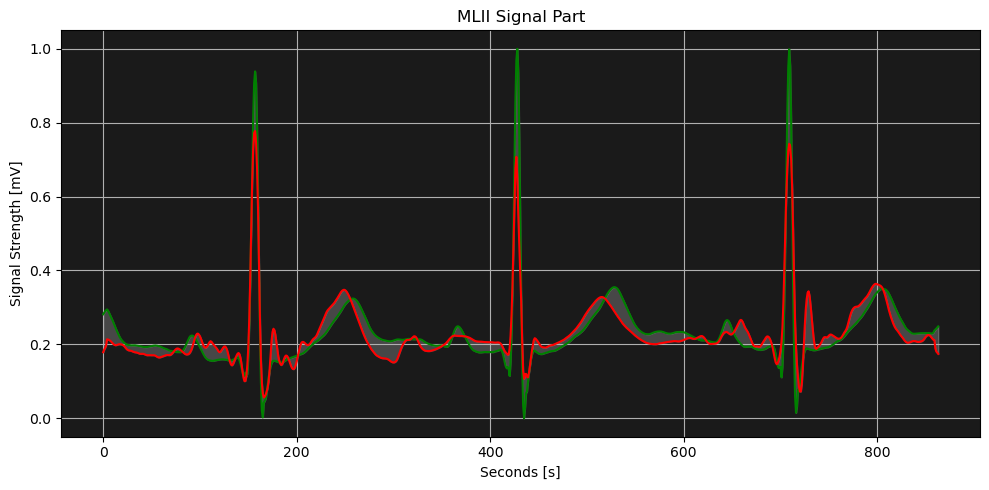

In [64]:
fig, ax = plt.subplots(figsize=(10,5))

plot_signal_data(ax, range(864), sss[:864])
plot_signal_data(ax, range(864), sig[0], plot_kws={"c": "red"})
plot_between_signals(ax, range(864), sss[:864], sig[0], plot_kws={"color": "white", "alpha": 0.2})

plt.grid()
plt.tight_layout()
plt.show()

In [66]:
np.mean(np.square(sss - sig), axis=1)

array([0.00228403])

In [129]:
np.argwhere(signal >= np.quantile(signal, 0.99)).shape

(115083, 1)

In [117]:
len(annotations)

108674

In [157]:
s_part = np.hstack([signal[169-int(128*1.2):169], signal[169:169+int(128*1.2)]])
ss = transformer.transform_signal(s_part)

np.argwhere(ss > 0.5).shape

(24, 1)

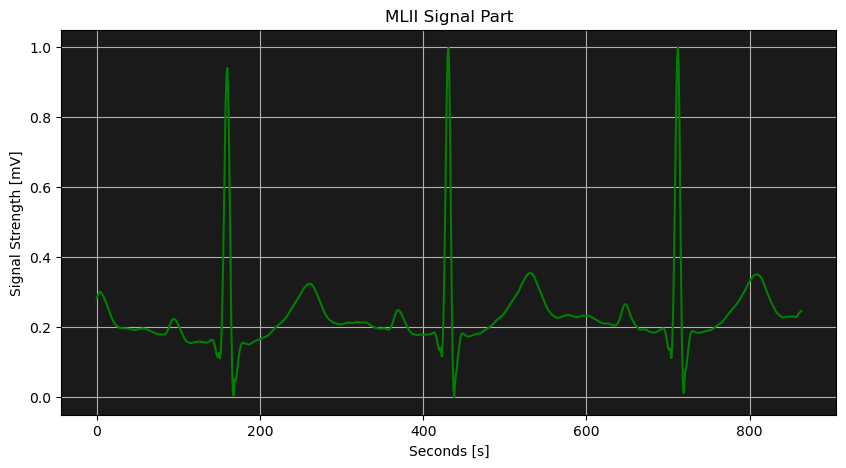

In [155]:
fig, ax = plt.subplots(figsize=(10,5))
plot_signal_data(ax, range(864), ss)
plt.show()

In [104]:
ttt = find_peaks(signal, height=1)[0]

In [106]:
ttt[]

9652

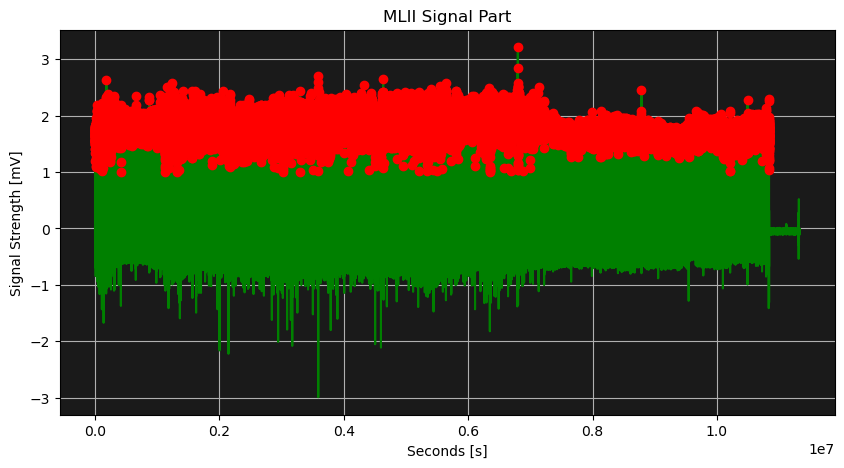

In [110]:
sts = signal

fig, ax = plt.subplots(figsize=(10,5))

plot_signal_data(ax, range(len(sts)), sts)

ax.plot(ttt, sts[ttt], 'ro')

plt.show()

In [150]:
for idx, ig in enumerate(symbols):
    if ig == "A":
        print(idx)

1006
1106


In [151]:
annotations[5]

1113

In [193]:
gg = np.hstack([signal[281437-int(360*1.2):281437], signal[281437:281437+int(360*1.2)]])

In [195]:
ggt = transformer.transform_signal(gg)

In [197]:
ggp = model.predict(ggt)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [199]:
ggp[0][0].shape

(864,)

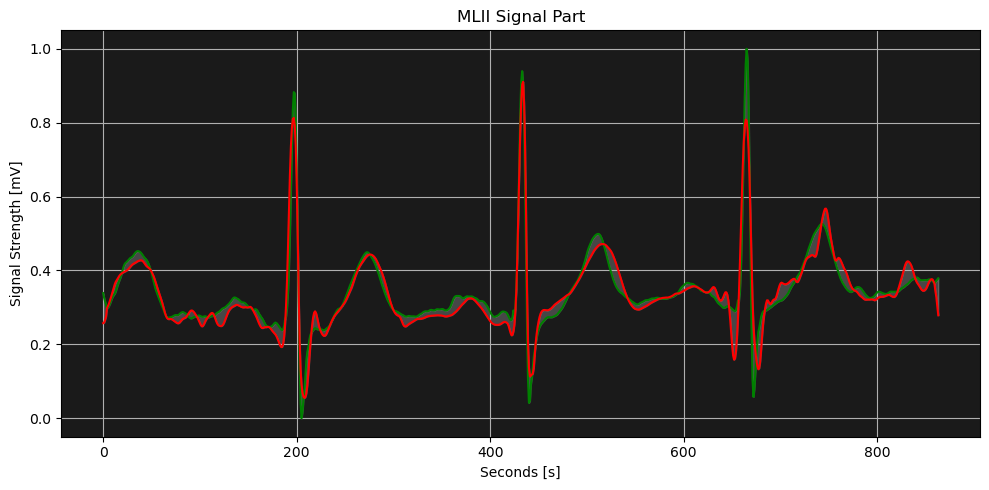

In [201]:
fig, ax = plt.subplots(figsize=(10,5))

plot_signal_data(ax, range(864), ggt)
plot_signal_data(ax, range(864), ggp[0][0], plot_kws={"c": "red"})
plot_between_signals(ax, range(864), ggt, ggp[0][0], plot_kws={"color": "white", "alpha": 0.2})

plt.grid()
plt.tight_layout()
plt.show()

In [203]:
ggp

(array([[0.25737208, 0.25879648, 0.26607728, 0.27536073, 0.29868534,
         0.30380735, 0.3104974 , 0.31826708, 0.32658345, 0.33570164,
         0.3454501 , 0.3548641 , 0.36288992, 0.36921528, 0.37376592,
         0.37790686, 0.38235036, 0.38650572, 0.38954237, 0.3917788 ,
         0.3936483 , 0.39522207, 0.39651045, 0.39781427, 0.39932418,
         0.40122527, 0.40351757, 0.4065115 , 0.40981135, 0.4129843 ,
         0.4156236 , 0.41757846, 0.4190044 , 0.42045796, 0.42215738,
         0.423978  , 0.42543414, 0.42639208, 0.4271566 , 0.42758307,
         0.42684278, 0.4250587 , 0.421966  , 0.41806692, 0.41429985,
         0.41129526, 0.4091553 , 0.40739217, 0.4050071 , 0.40137252,
         0.39668104, 0.39121187, 0.3851407 , 0.37805054, 0.36985376,
         0.36119857, 0.35283548, 0.34454522, 0.3369105 , 0.32955498,
         0.32182214, 0.31315196, 0.3035787 , 0.2936912 , 0.28430566,
         0.27666155, 0.27136922, 0.26869997, 0.26818496, 0.26879475,
         0.26880217, 0.26776078, 0

In [175]:
annotations[np.array(symbols) == "V"]

array([282126], dtype=int64)

In [173]:
type(symbols)

list

In [187]:
type(annotations)

numpy.ndarray

In [191]:
annotations[annotations > 281000]

array([281035, 281202, 281437, ..., 649387, 649627, 649857], dtype=int64)

In [39]:
d, u = np.unique(np.array(symbols), return_counts=True)
dict(zip(d, u))

{'+': 28, 'A': 72, 'F': 14, 'N': 2029, 'V': 473, 'a': 1, 'e': 16, '~': 10}